In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft, fftfreq
from scipy.io import loadmat
import xlsxwriter 
%matplotlib inline

In [2]:
def NGD(x,alpha,beta,K,g,phi):
    y=np.zeros(len(x))
    z=np.zeros(len(x))
    for j in range(len(x)-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        y[j+1]=y[j]+dy
        z[j+1]=z[j]+dz
    return y,z

In [3]:
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate

In [4]:
def MI(xstate,ystate,dt,window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftdu=dt # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen))
    xedges=np.arange(min(xstate),max(xstate)+0.0001)
    yedges=np.arange(min(ystate),max(ystate)+0.0001)
    
    # shifted data
    # shift>0 => y shifted to positive side
    MIvalue=np.zeros(len(bitshift))
    for i in range(len(bitshift)):
        xx=[]
        yy=[]
        shift=int(bitshift[i])
        if shift>0:
            xx=xstate[shift:]
            yy=ystate[:-shift]
        elif shift==0:
            xx=xstate
            yy=ystate
        elif shift<0:
            xx=xstate[:shift]
            yy=ystate[-shift:]

        H, xedges, yedges = np.histogram2d(xx, yy, bins=(xedges, yedges))
        statesum=np.sum(H)
        px_list=np.sum(H,axis=1)/statesum
        py_list=np.sum(H,axis=0)/statesum
        pxy_list=H/statesum

        MIsingle=np.zeros((len(px_list),len(py_list)))
        for ix in range(len(px_list)):
            for iy in range(len(py_list)):
                if pxy_list[ix][iy]==0:
                    MIsingle[ix][iy]=0
                else:
                    MIsingle[ix][iy]=pxy_list[ix][iy]*math.log2(pxy_list[ix][iy]/px_list[ix]/py_list[iy])/dt
        MIvalue[i]=np.sum(MIsingle)
    return timeshift,MIvalue

In [5]:
# generate OU
def OU(tau,fc,dt,Seed):
    Tot=300
    T=np.arange(dt,Tot,dt)
    D = 4
    L=np.zeros(len(T))
    for i in range(len(T)-1):
        L[i+1]=L[i]*(1-dt/tau)+math.sqrt(D*dt)*Seed[i]

    # filtering
    if fc!='no':
        b, a = signal.butter(2, 2*fc*dt, btype='low', analog=False)
        Lf = signal.filtfilt(b, a, L)
        x=Lf
    else:
        x=L
    return x

In [6]:
def FFT_quick(data,dt):
    Ts=dt
    xft=fft(data)
    xftreal = xft.real  
    xftimg = xft.imag
    xft_abs=abs(xft)
    xft_nor=xft_abs/len(xft_abs)
    xft_nor2=xft_nor[range(int(len(xft_nor)/2))]
    freq=fftfreq(len(data), d=dt)
    freq=freq[range(int(len(freq)/2))]
    phase=np.angle(xft)
    phase=phase[range(int(len(phase)/2))]
    
    return freq,xft_nor2,phase

In [7]:
def xcorr_quick(x,y,window_size):
    lags=np.arange(-int(window_size/dt),int(window_size/dt)+1e-5)
    lags=lags.astype(int)
    corr=np.zeros(len(lags))
    timelag=lags*dt
    for icorr in range(len(lags)):
        if lags[icorr]<0:
            corr[icorr]=np.sum(x[:lags[icorr]]*y[-lags[icorr]:])#/len(x[:-1+lags[icorr]])
        elif lags[icorr]==0:
            corr[icorr]=np.sum(x*y)#/len(x)
        else:
            corr[icorr]=np.sum(x[lags[icorr]:]*y[:-lags[icorr]])#/len(x[lags[icorr]:])
    return timelag,corr

(200.0, 300.0)

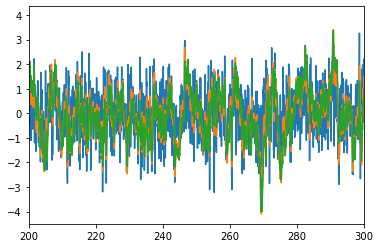

In [8]:
# generate OU input (different tau and different cutoff frequency)
tau_set=[0.1,0.6,1] 
fc=['no',10,7,4,2]
dt=0.01
Tot=300
T=np.arange(dt,Tot,dt)
mu, sigma = 0, 1
ran_seed=np.random.normal(mu,sigma,len(T))
x_set=[[OU(tau_set[j],fc[i],dt,ran_seed) for i in range(len(fc))] for j in range(len(tau_set))]
x_set=[[x_set[j][i]/np.std(x_set[j][i]) for i in range(len(fc))] for j in range(len(tau_set))]
# mean_inten=10 # set a mean intensity of the stimulus
# for i in range(len(tau_set)): 
#     for j in range(len(fc)):
#         x_set[i][j]=mean_inten/5*x_set[i][j]/np.std(x_set[i][j])
#         x_set[i][j]=x_set[i][j]-np.mean(x_set[i][j])+mean_inten

for i in range(len(tau_set)):
    plt.plot(T,x_set[i][1])
plt.xlim(200,300)

## generate NGD kernel

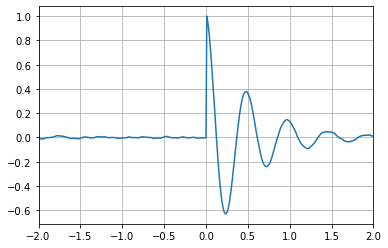

In [9]:
alpha,beta,K,g=4,1.6,16,10
total_loop=10  # run 50 loops
corr_window=100
corr_sum=np.zeros(2*int(corr_window/dt)+1)
for num_loop in range(total_loop):
    mu, sigma = 0, 1
    xran4=np.random.normal(mu,sigma,len(T))
    y4,z4=NGD(xran4,alpha,beta,K,g,1)
    timelag100,Crand=xcorr_quick(xran4,y4,corr_window)
    corr_sum+=Crand
corr_sum=corr_sum/total_loop


plt.plot(timelag100,corr_sum[::-1]/max(corr_sum))
plt.xlim(-2,2)
plt.grid()

In [10]:
# alpha,beta,K,g=6,1.6,15,10
y_set=[[NGD(x_set[i][j],alpha,beta,K,g,1)[0] for j in range(np.size(x_set,1))] for i in range(np.size(x_set,0))]
z_set=[[NGD(x_set[i][j],alpha,beta,K,g,1)[1] for j in range(np.size(x_set,1))] for i in range(np.size(x_set,0))]
# y_set is a 2d list 
# y_set[diffrent tau][different fc] 

In [11]:
# cross correlation
window_size=5
corr_set=[[[] for j in range(np.size(x_set,1))] for i in range(np.size(x_set,0))]
for i in range(np.size(x_set,0)):
    for j in range(np.size(x_set,1)):
        timelag,corr_set[i][j]=xcorr_quick(x_set[i][j],y_set[i][j],window_size)

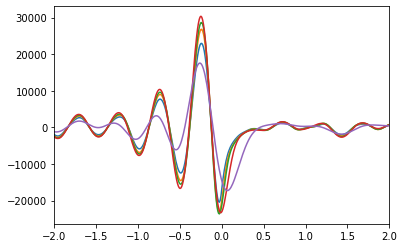

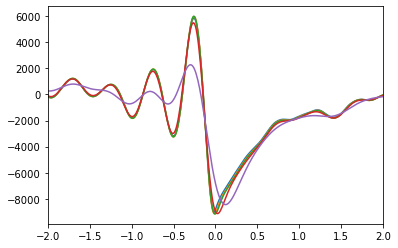

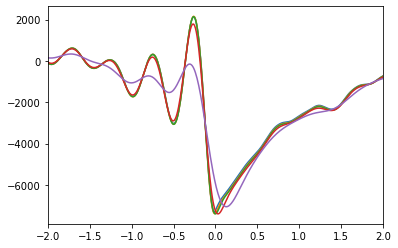

In [12]:
for i in range(np.size(x_set,1)):    
    plt.plot(timelag,-corr_set[0][i])
    plt.xlim(-2,2)
plt.show()
for i in range(np.size(x_set,1)):
    plt.plot(timelag,-corr_set[1][i])
    plt.xlim(-2,2)
plt.show()
for i in range(np.size(x_set,1)):    
    plt.plot(timelag,-corr_set[2][i])
    plt.xlim(-2,2)
plt.show()

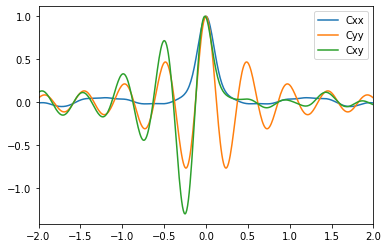

In [13]:
ntau,nfc=0,3
x=x_set[ntau][nfc]
y=y_set[ntau][nfc]
z=z_set[ntau][nfc]

# cross correlation
timelag,Cxx=xcorr_quick(x,x,5)
plt.plot(timelag,Cxx/max(Cxx))
timelag,Cyy=xcorr_quick(y,y,5)
plt.plot(timelag,Cyy/max(Cyy))
timelag,Cxy=xcorr_quick(x,y,5)
plt.plot(timelag,Cxy/max(Cxy))
plt.xlim(-2,2)
plt.legend(('Cxx','Cyy','Cxy'))

## result for NGD model

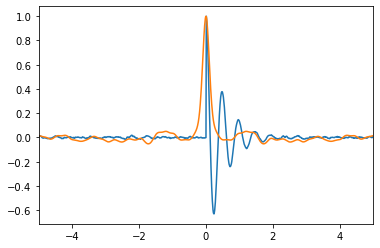

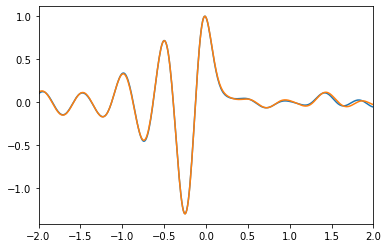

(-2.0, 2.0)

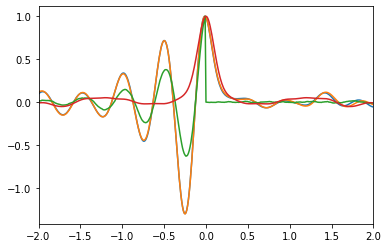

In [14]:
temp_kernel=corr_sum[::-1]/max(corr_sum)
plt.plot(timelag100,temp_kernel)
timelag100,Cxx=xcorr_quick(x,x,100)
plt.plot(timelag100,Cxx/max(Cxx))
plt.xlim(-5,5)
plt.show()

timelag1,Cxx_k=xcorr_quick(Cxx,temp_kernel,5) 
plt.plot(timelag1,Cxx_k/max(Cxx_k))
plt.plot(timelag,Cxy/max(Cxy))
plt.xlim(-2,2)
plt.show()
plt.plot(timelag1,Cxx_k/max(Cxx_k))
plt.plot(timelag,Cxy/max(Cxy))
plt.plot(timelag100,corr_sum/max(corr_sum))
plt.plot(timelag100,Cxx/max(Cxx))
plt.xlim(-2,2)

## Load data / find auto-correlation of ganglion cell output

1469


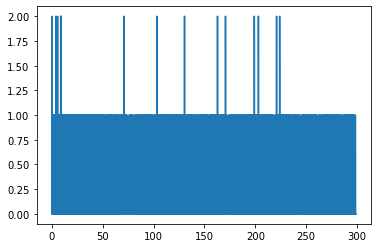

In [15]:
path_spike='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200419/'
file1='OU_tau=100ms_cutoff=4_19-Apr-2020_0_sort_unit1.mat'
# file1='OU_tau=600ms_19-Apr-2020_0_sort_unit1.mat'
# file1='OU_tau=600ms_cutoff=10_19-Apr-2020_0_sort_unit1.mat'
# file1='OU_tau=600ms_cutoff=4_19-Apr-2020_0_sort_unit1.mat'
# file1='OU_tau=600ms_cutoff=2_19-Apr-2020_0_sort_unit1.mat'

# path_spike='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200318/'
# file1='20200318_OU_tau=op5_fc=10_2_sort_unit1.mat'

data1=loadmat(path_spike+file1)
spikes=data1['Spikes'][0][38][0]
timestamp=data1['TimeStamps'][0]

adata1=data1['a_data'][0]
t=np.arange(1,len(adata1)+1e-5)/20000
sti=adata1[(t>timestamp[0]) & (t<timestamp[1])][0:-1:200]
sti=sti-np.mean(sti)

spikes1=spikes[(spikes>timestamp[0]) & (spikes<timestamp[1])]-timestamp[0]
BinningTime=np.arange(0,timestamp[1]-timestamp[0],dt)
BinningSpikes, bin_edges=np.histogram(spikes1,bins=BinningTime)

plt.plot(bin_edges[:-1],BinningSpikes)
# plt.xlim(100,120)
print(np.sum(BinningSpikes))

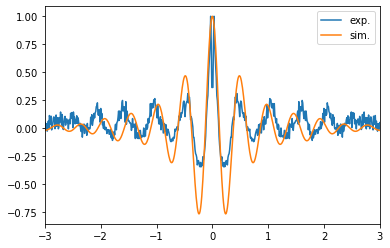

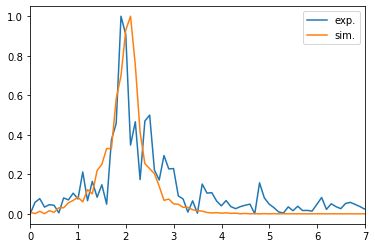

In [16]:
tl,Cyy_exp=xcorr_quick(BinningSpikes-np.mean(BinningSpikes),BinningSpikes-np.mean(BinningSpikes),5)
Cyy_exp[np.argmax(Cyy_exp)]=Cyy_exp[np.argmax(Cyy_exp)+1]
plt.plot(tl,Cyy_exp/max(Cyy_exp))
plt.plot(timelag,Cyy/max(Cyy))
plt.xlim(-3,3)
plt.legend(('exp.','sim.'))
plt.show()

freq,p_exp,ph_exp=FFT_quick(Cyy_exp,dt)
p_exp[0]=0
plt.plot(freq,p_exp/max(p_exp))
freq,p_sim,ph_sim=FFT_quick(Cyy,dt)
plt.plot(freq,p_sim/max(p_sim))
plt.xlim(0,7)
plt.legend(('exp.','sim.'))

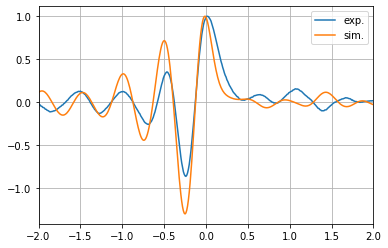

In [17]:
tl_exp,Csti_spike=xcorr_quick(sti[:len(BinningSpikes)],BinningSpikes,5)
# plt.plot(tl,Cyy_exp/max(Cyy_exp))
plt.plot(tl_exp,Csti_spike/min(Csti_spike))
plt.plot(timelag,corr_set[ntau][nfc]/max(corr_set[ntau][nfc]))
plt.xlim(-2,2)
plt.grid()
plt.legend(('exp.','sim.'))

## kernel in experiment (white noise STA)

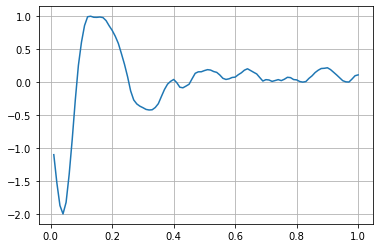

In [18]:
path='F:/我的雲端硬碟/Retina exp/exp data/Sorted_final_data/20200419/MIandSTA/'
fileSTA='cSTA_19-Apr-2020_0_sort_unit1_STA.mat'
expdataSTA=loadmat(path+fileSTA)
STA_data=expdataSTA['STAAAAA']
TS=expdataSTA['TimeShift']
TS=TS[0][0][0]
STA=STA_data[0][32][0]
kernel_exp=STA[::-1][TS>0]-10
tk=TS[TS>0]
plt.plot(tk/1000,kernel_exp)
# plt.xlim(0,2000)
plt.grid()
plt.show()

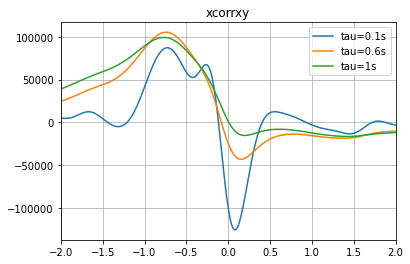

In [19]:
for i in range(3):
    x=x_set[i][4]
    y_kernel_exp=np.convolve(x,kernel_exp,'valid')
    tl_kernel_exp,Cxy_kernel_exp=xcorr_quick(x[len(kernel_exp)-1:],y_kernel_exp,5)
    plt.plot(tl_kernel_exp,Cxy_kernel_exp)
plt.xlim(-2,2)
plt.grid()
plt.title('xcorrxy')
plt.legend(('tau=0.1s','tau=0.6s','tau=1s'))